In [1]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.extmath import cartesian

import numpy as np
import time as T
import matplotlib.pyplot as plt

In [2]:
# Generates a sequence based on mu, alpha, omega values
# Uses Ogata's thinning method, with some speedups

def generate_seq(horizon, alpha, mu, omega):
    alpha, mu = np.array(alpha), np.array(mu)
    dim = mu.shape[0]
    data = []  # clear history
    Istar = np.sum(mu)
    s = np.random.exponential(scale=1./Istar)

    # attribute (weighted random sample, since sum(mu)==Istar)
    n0 = np.random.choice(np.arange(dim), 1, p=(mu/Istar))
    data.append([s, n0])

    # value of \lambda(t_k) where k is most recent event
    # starts with just the base rate
    lastrates = mu.copy()

    decIstar = False
    while True:
        tj, uj = data[-1][0], int(data[-1][1])
        if decIstar:
            # if last event was rejected, decrease Istar
            Istar = np.sum(rates)
            decIstar = False
        else:
            # otherwise, we just had an event, so recalc Istar (inclusive of last event)
            Istar = np.sum(lastrates) + omega * np.sum(alpha[:,uj])
            
        # generate new event
        s += np.random.exponential(scale=1./Istar)

        # calc rates at time s (use trick to take advantage of rates at last event)
        rates = mu + np.exp(-omega * (s - tj)) * \
                (alpha[:,uj].flatten() * omega + lastrates - mu)

        # attribution/rejection test
        # handle attribution and thinning in one step as weighted random sample
        diff = Istar - np.sum(rates)
        try:
            n0 = np.random.choice(np.arange(dim+1), 1, p=(np.append(rates, diff)/Istar))
        except ValueError:
            # by construction this should not happen
            print('Probabilities do not sum to one.')
            data = np.array(data)
            return data

        if n0 < dim:
            data.append([s, n0])
            # update lastrates
            lastrates = rates.copy()
        else:
            decIstar = True

        # if past horizon, done
        if s >= horizon:
            data = np.array(data)
            data = data[data[:,0] < horizon]
            return data

In [3]:
# horizon = 60, alpha = [[0.5]], mu = [0.1], omega = 1.0
seq = generate_seq(60, [[0.5]], [0.1], 1.0)
print(seq)

print(len(seq))

[[14.535917903932816 array([0])]]
1


In [4]:
# Visualization method to plot events

def plot_events(horizon, alpha, mu, omega, horizonViz=-1, showDays=True, labeled=True):
    alpha, mu = np.array(alpha), np.array(mu)
    dim = mu.shape[0]
    data = generate_seq(horizon, alpha, mu, omega)
    
    if horizonViz < 0:
        horizonViz = np.amax(data[:,0])

    fig = plt.figure(figsize=(10,2))
    ax = plt.gca()
    for i in range(dim):
        subseq = data[data[:,1]==i][:,0]
        plt.plot(subseq, np.zeros(len(subseq)) - i, 'bo', alpha=0.2)

    if showDays:
        for j in range(1,int(horizonViz)):
            plt.plot([j,j], [-dim, 1], 'k:', alpha=0.15)

    if labeled:
        ax.set_yticklabels('')
        ax.set_yticks(-np.arange(0, dim), minor=True)
        ax.set_yticklabels([r'$e_{%d}$' % i for i in range(dim)], minor=True)
    else:
        ax.yaxis.set_visible(False)

    ax.set_xlim([0,horizonViz])
    ax.set_ylim([-dim, 1])
    ax.set_xlabel('Time')
    plt.tight_layout()
    
    print(data)

[[2.637436380728602 array([0])]
 [4.789671937429676 array([0])]
 [5.701705167130598 array([0])]
 [7.926706090224542 array([0])]
 [9.37041370957529 array([0])]
 [9.779926063804266 array([0])]
 [9.871780156837456 array([0])]
 [9.877745368913768 array([0])]
 [10.674414841678535 array([0])]
 [11.34561730001782 array([0])]
 [39.05218959678314 array([0])]
 [43.27965803258956 array([0])]
 [45.9892104004248 array([0])]
 [56.4834469914614 array([0])]
 [56.60268893090766 array([0])]
 [57.38590602090397 array([0])]]


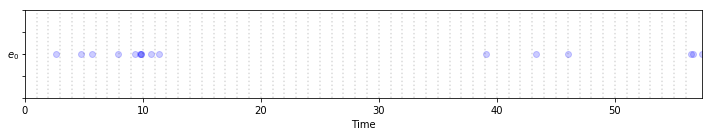

In [5]:
# horizon = 60, alpha = [[0.5]], mu = [0.1], omega = 1.0
plot_events(60, [[0.5]], [0.1], 1.0)

[[14.943139464894825 array([0])]
 [15.178723225644612 array([1])]
 [15.216113921403107 array([2])]
 [18.559111476474648 array([0])]
 [18.857905729741198 array([0])]
 [22.082708347669396 array([0])]
 [22.098500819330855 array([1])]
 [23.884355423387028 array([0])]
 [24.219002267454083 array([0])]
 [32.04641130589961 array([0])]
 [36.10900030416823 array([0])]
 [36.26261123395113 array([1])]
 [37.87259129048434 array([0])]
 [37.92787159143671 array([1])]
 [38.26965889496692 array([2])]
 [38.397650064468635 array([2])]
 [39.83453510862351 array([0])]
 [48.07807789056751 array([0])]
 [48.099285086214614 array([1])]
 [48.943634940245616 array([0])]
 [59.991042392753755 array([0])]]


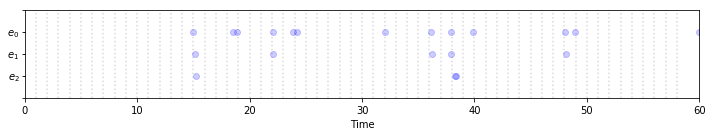

In [6]:
alpha = [[0.1, 0.0, 0.0], 
         [0.9, 0.0, 0.0],
         [0.0, 0.9, 0.0]]
mu = [0.2, 0.0, 0.0]
omega = 3.1
horizon = 60

plot_events(horizon, alpha, mu, omega)

In [7]:
# Visualization methods for rates

def get_rate(horizon, alpha, mu, omega, ct, d):
    alpha, mu = np.array(alpha), np.array(mu)
    dim = mu.shape[0]
    data = generate_seq(horizon, alpha, mu, omega)
    
    # return rate at time ct in dimension d
    seq = np.array(data)
    if not np.all(ct > seq[:,0]): seq = seq[seq[:,0] < ct]
    return mu[d] + np.sum([alpha[d,int(j)] * omega * np.exp(-omega*(ct-t)) for t,j in seq])

def plot_rates(horizon, alpha, mu, omega, horizonViz=-1):
    alpha, mu = np.array(alpha), np.array(mu)
    dim = mu.shape[0]
    data = generate_seq(horizon, alpha, mu, omega)
    
    # finish up this function to plot when dim != 3
    if dim != 3:
        print('Not yet implemented.')
        return

    if horizonViz < 0:
        horizonViz = np.amax(data[:,0])

    f, axarr = plt.subplots(6,1, sharex='col', 
                            gridspec_kw = {'height_ratios':[3,1,3,1,3,1]}, 
                            figsize=(8,5))
    xs = np.linspace(0, horizonViz, (horizonViz/100.)*1000)
    for i in range(dim):
        row = i * 2

        # plot rate
        r = [get_rate(horizon, alpha, mu, omega, ct, i) for ct in xs]
        axarr[row].plot(xs, r, 'k-')
        axarr[row].set_ylim([-0.01, np.amax(r)+(np.amax(r)/2.)])
        axarr[row].set_ylabel('$\lambda(t)_{%d}$' % i, fontsize=14)
        r = []

        # plot events
        subseq = data[data[:,1]==i][:,0]
        axarr[row+1].plot(subseq, np.zeros(len(subseq)) - 0.5, 'bo', alpha=0.2)
        axarr[row+1].yaxis.set_visible(False)

        axarr[row+1].set_xlim([0, horizonViz])

    plt.tight_layout()

In [8]:
# horizon = 60, alpha = [[0.5]], mu = [0.1], omega = 1.0
plot_rates(60, [[0.5]], [0.1], 1.0)

Not yet implemented.


/Users/agnikumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


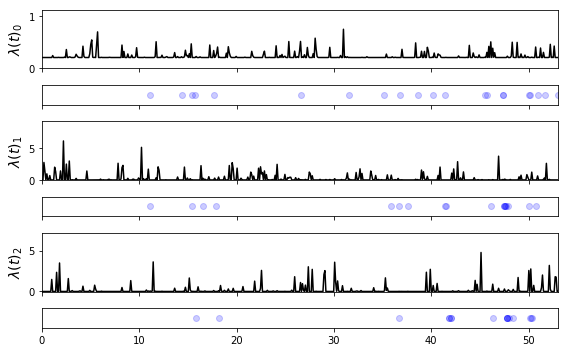

In [9]:
alpha = [[0.1, 0.0, 0.0], 
         [0.9, 0.0, 0.0],
         [0.0, 0.9, 0.0]]
mu = [0.2, 0.0, 0.0]
omega = 3.1
horizon = 60

plot_rates(horizon, alpha, mu, omega)

In [10]:
def EM(data, Ahat, mhat, omega, seq=[], smx=None, tmx=None, regularize=False, 
       Tm=-1, maxiter=100, epsilon=0.01, verbose=True):
    '''implements MAP EM. Optional to regularize with 'smx' and 'tmx' matrix (shape=(dim,dim)).
    In general, the 'tmx' matrix is a pseudocount of parent events from column j,
    and the 'smx' matrix is a pseudocount of child events from column j -> i'''

    # if no sequence passed, uses class instance data
    if len(seq) == 0:
        seq = data

    N = len(seq)
    dim = mhat.shape[0]
    Tm = float(seq[-1,0]) if Tm < 0 else float(Tm)
    sequ = seq[:,1].astype(int)

    p_ii = np.random.uniform(0.01, 0.99, size=N)
    p_ij = np.random.uniform(0.01, 0.99, size=(N, N))

    # PRECOMPUTATIONS

    # diffs[i,j] = t_i - t_j for j < i (o.w. zero)
    diffs = pairwise_distances(np.array([seq[:,0]]).T, metric = 'euclidean')
    diffs[np.triu_indices(N)] = 0

    # kern[i,j] = omega*np.exp(-omega*diffs[i,j])
    kern = omega*np.exp(-omega*diffs)

    colidx = np.tile(sequ.reshape((1,N)), (N,1))
    rowidx = np.tile(sequ.reshape((N,1)), (1,N))

    # approx of Gt sum in a_{uu'} denom
    seqcnts = np.array([len(np.where(sequ==i)[0]) for i in range(dim)])
    seqcnts = np.tile(seqcnts, (dim,1))

    # returns sum of all pmat vals where u_i=a, u_j=b
    def sum_pij(a,b):
        c = cartesian([np.where(seq[:,1]==int(a))[0], np.where(seq[:,1]==int(b))[0]])
        return np.sum(p_ij[c[:,0], c[:,1]])
    vp = np.vectorize(sum_pij)

    # \int_0^t g(t') dt' with g(t)=we^{-wt}
    # def G(t): return 1 - np.exp(-omega * t)
    #   vg = np.vectorize(G)
    # Gdenom = np.array([np.sum(vg(diffs[-1,np.where(seq[:,1]==i)])) for i in range(dim)])
    k = 0
    old_LL = -10000
    START = T.time()
    while k < maxiter:
        Auu = Ahat[rowidx, colidx]
        ag = np.multiply(Auu, kern)
        ag[np.triu_indices(N)] = 0

        # compute m_{u_i}
        mu = mhat[sequ]

        # compute total rates of u_i at time i
        rates = mu + np.sum(ag, axis=1)

        # compute matrix of p_ii and p_ij  (keep separate for later computations)
        p_ij = np.divide(ag, np.tile(np.array([rates]).T, (1,N)))
        p_ii = np.divide(mu, rates)

        # compute mhat: mhat_u = (\sum_{u_i=u} p_ii) / T
        mhat = np.array([np.sum(p_ii[np.where(seq[:,1]==i)]) \
                         for i in range(dim)]) / Tm

        # ahat_{u,u'} = (\sum_{u_i=u}\sum_{u_j=u', j<i} p_ij) / \sum_{u_j=u'} G(T-t_j)
        # approximate with G(T-T_j) = 1
        if regularize:
            Ahat = np.divide(np.fromfunction(lambda i,j: vp(i,j), (dim,dim)) + (smx-1),
                             seqcnts + tmx)
        else:
            Ahat = np.divide(np.fromfunction(lambda i,j: vp(i,j), (dim,dim)),
                             seqcnts)

        if k % 10 == 0:
            try:
                term1 = np.sum(np.log(rates))
            except:
                print('Log error!')
            term2 = Tm * np.sum(mhat)
            term3 = np.sum(np.sum(Ahat[u,int(seq[j,1])] for j in range(N)) for u in range(dim))
            #new_LL = (1./N) * (term1 - term2 - term3)
            new_LL = (1./N) * (term1 - term3)
            if abs(new_LL - old_LL) <= epsilon:
                if verbose:
                    print('Reached stopping criterion. (Old: %1.3f New: %1.3f)' % (old_LL, new_LL))
                return Ahat, mhat
            if verbose:
                print('After ITER %d (old: %1.3f new: %1.3f)' % (k, old_LL, new_LL))
                print(' terms %1.4f, %1.4f, %1.4f' % (term1, term2, term3))

            old_LL = new_LL

        k += 1

    if verbose:
        print('Reached max iter (%d).' % maxiter)
    
    print(rates) 
    #return Ahat, mhat
    
    return Ahat, mhat, rates 

In [11]:
alpha = [[0.1, 0.0, 0.0], 
         [0.9, 0.0, 0.0],
         [0.0, 0.9, 0.0]]
mu = [0.2, 0.0, 0.0]
omega = 3.1
horizon = 60

data = generate_seq(horizon, alpha, mu, omega)

mhat = np.random.uniform(0,1, size=3)
ahat = np.random.uniform(0,1, size=(3,3))
w = 3.

print(EM(data, ahat, mhat, w))

After ITER 0 (old: -10000.000 new: -0.089)
 terms 10.6124, 10.3342, 12.6658
After ITER 10 (old: -0.089 new: -1.183)
 terms -12.6544, 8.4437, 14.5563
Reached stopping criterion. (Old: -1.183 New: -1.183)
(array([[1.81835189e-011, 6.97110244e-002, 5.56177676e-261],
       [8.03163649e-001, 1.15297448e-005, 1.28572487e-001],
       [1.24645862e-011, 4.92735012e-001, 3.43019984e-001]]), array([1.40725730e-01, 3.94616773e-18, 9.58273702e-28]))


/Users/agnikumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
